git repo source url - https://github.com/emanhamed/Houses-dataset

@article{ahmed2016house, title={House price estimation from visual and textual features}, author={Ahmed, Eman and Moustafa, Mohamed}, journal={arXiv preprint arXiv:1609.08399}, year={2016} }

## get attribute information about the houses and add them to the images of the houses
Attribute Information:Number of Bedrooms, Number of bathrooms, Area,Zipcod, Price

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import locale
import pandas as pd
import os
import csv


cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv('./HousesDataset/HousesInfo.txt', sep=" ", header=None, names=cols)
zipcodes = df["zipcode"].value_counts().keys().tolist()
counts = df["zipcode"].value_counts().tolist()

# loop over each of the unique zip codes and their corresponding
# count

for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

df.head()


Using TensorFlow backend.


,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000.0
32,3,2.0,1802,93446,365000.0
39,3,3.0,2146,93446,455000.0
80,4,2.5,2464,91901,599000.0
81,2,2.0,1845,91901,529800.0


In [33]:
ls=list(df.index)
ls.index(211)
df.iloc[101:103,:]

,bedrooms,bathrooms,area,zipcode,price
211,3,2.5,1678,94501,668000.0
212,2,1.0,1134,94501,599000.0


In [2]:
### load image data

def load_house_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []

    # loop over the indexes of the houses
    for i in df.index.values:
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))

        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((64, 64, 3), dtype="uint8")

        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)

        # tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:32, 0:32] = inputImages[0]
        outputImage[0:32, 32:64] = inputImages[1]
        outputImage[32:64, 32:64] = inputImages[2]
        outputImage[32:64, 0:32] = inputImages[3]

        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)

    # return our set of images
    return np.array(images)
images = load_house_images(df, './HousesDataset/')
images = images / 255.0
images.shape

(362, 64, 64, 3)

In [3]:

## function to prepare for combining images as well as the house attributes 
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
trainImagesX.shape, testImagesX.shape,trainY.shape, testY.shape


((271, 64, 64, 3), (91, 64, 64, 3), (271,), (91,))

In [4]:
### combine image data with house attributes to create trainX 
trainX,testX =process_house_attributes(df,trainAttrX, testAttrX)
trainX.shape, testX.shape , trainY.shape, testY.shape

((271, 10), (91, 10), (271,), (91,))

In [11]:
trainX[:5]

array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.44444444, 0.45454545, 0.56262899],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.11111111, 0.18181818, 0.0754088 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.22222222, 0.36363636, 0.3332275 ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.33333333, 0.36363636, 0.34434037],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.11111111, 0.18181818, 0.11732021]])

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error ,mean_squared_error, r2_score
import pickle
models=[]
models.append(('LM',LinearRegression()))
models.append(('KNN',KNeighborsRegressor(n_neighbors=2)))
models.append(('TREE',DecisionTreeRegressor(max_depth=2)))
models.append(('RF',RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)))

err=1
best_model=None
best_model_name=None
for name, model in models:
    model.fit(trainX,trainY)
    y_pred = model.predict(testX)
    error= mean_absolute_error(testY, y_pred)
    print ("---------- model: " + name + '   performance as following --------->')
    print("mean absolute error: " + str(round(error,4)))

    
    if err > error :
        err= round(error,4)
        best_model=model
        best_model_name=name



predicted=best_model.predict(testX)
error= mean_absolute_error(testY, y_pred)
print("mean absolute error :",err)
# save the model to disk
filename = '{}_model.pkl'.format(best_model_name)
pickle.dump(best_model, open(filename, 'wb'))



---------- model: LM   performance as following --------->
mean absolute error: 0.021
---------- model: KNN   performance as following --------->
mean absolute error: 0.0331
---------- model: TREE   performance as following --------->
mean absolute error: 0.0297
---------- model: RF   performance as following --------->
mean absolute error: 0.0293
mean absolute error : 0.021


In [5]:
trainX_img=trainImagesX.reshape(271,64*64*3)
testX_img= testImagesX.reshape(91,64*64*3)
trainX_img.shape, testX_img.shape

((271, 12288), (91, 12288))

In [6]:
X_train =np.hstack((trainX_img, trainX)).reshape(271,12298,1)
X_test = np.hstack((testX_img, testX)).reshape(91,12298,1)

X_train.shape, X_test.shape 

((271, 12298, 1), (91, 12298, 1))

In [7]:
trainY=trainY.values
testY=testY.values
trainY.shape, testY.shape

((271,), (91,))

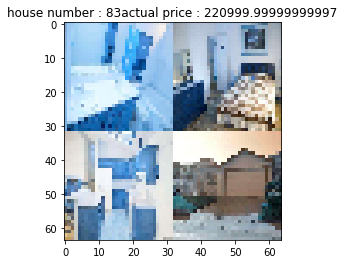

In [8]:
### plot the images of a randomly selected house house
import random
import matplotlib.pyplot as plt
%matplotlib inline
rn=random.randint(0,trainImagesX.shape[0])
plt.imshow(trainImagesX[rn,:,:,:])

plt.title("house number : "+str(rn) + "actual price : " +str(trainY[rn]*maxPrice))
plt.show()


In [55]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.convolutional import MaxPooling2D,MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

def create_cnn3(inputshape, filters=(16,32,64,128,256,512,1024), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    #inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputshape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv1D(f,  3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling1D(pool_size=2)(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint
# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# price *predictions* and the *actual prices*
model = create_cnn(64, 64, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# add checkpoint to save the model
checkpoint = ModelCheckpoint('./keras_CNN_regression.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# train the model
print("[INFO] training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
	epochs=200, batch_size=8, callbacks=callbacks_list)

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testImagesX)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
error= mean_absolute_error(testY, preds)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean abs error: {:.2f}%".format(error))

In [49]:
#create custom generator to shuffle the train data
import random
def data_gen(X,y, batch_size):
    idx=[random.randint(0,X.shape[0]) for _ in range(0,batch_size)]
    return X[idx], y[idx]

print(X_train.shape,trainY.shape)
X_,y_ = data_gen(X_train,trainY ,128)
X_.shape, y_.shape

(271, 12298, 1) (271,)


((128, 12298, 1), (128,))

generator

In [56]:
from keras.callbacks import ModelCheckpoint

model = create_cnn3((12298,1), regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

epochs=300
# add checkpoint to save the model

checkpoint = ModelCheckpoint('./cnn3_checkpoint.hdf5', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# train the model
print("[INFO] training model...")
model.fit(X_train, trainY, validation_data=(X_test, testY),
	epochs=epochs, batch_size=12, callbacks=callbacks_list)

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(X_test)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/300
271/271 [==============================] - 45s 167ms/step - loss: 1539.6545 - val_loss: 2646.1523

Epoch 00001: val_loss improved from -inf to 2646.15229, saving model to ./cnn3_checkpoint.hdf5
Epoch 2/300
271/271 [==============================] - 36s 133ms/step - loss: 1464.1542 - val_loss: 1295.7803

Epoch 00002: val_loss did not improve from 2646.15229
Epoch 3/300
271/271 [==============================] - 41s 153ms/step - loss: 1117.3894 - val_loss: 717.3286

Epoch 00003: val_loss did not improve from 2646.15229
Epoch 4/300
271/271 [==============================] - 37s 137ms/step - loss: 1071.7292 - val_loss: 929.9249

Epoch 00004: val_loss did not improve from 2646.15229
Epoch 5/300
271/271 [==============================] - 36s 134ms/step - loss: 1024.2945 - val_loss: 1277.3156

Epoch 00005: val_loss did not improve from 2646.15229
Epoch 6/300
271/271 [==============================] - 37s 135ms/s


Epoch 00100: val_loss did not improve from 2646.15229
Epoch 101/300
271/271 [==============================] - 37s 138ms/step - loss: 52.0109 - val_loss: 64.0806

Epoch 00101: val_loss did not improve from 2646.15229
Epoch 102/300
271/271 [==============================] - 36s 133ms/step - loss: 53.8885 - val_loss: 64.7420

Epoch 00102: val_loss did not improve from 2646.15229
Epoch 103/300
271/271 [==============================] - 38s 141ms/step - loss: 51.4698 - val_loss: 62.8481

Epoch 00103: val_loss did not improve from 2646.15229
Epoch 104/300
271/271 [==============================] - 36s 135ms/step - loss: 58.2688 - val_loss: 65.1259

Epoch 00104: val_loss did not improve from 2646.15229
Epoch 105/300
271/271 [==============================] - 38s 141ms/step - loss: 58.9486 - val_loss: 64.3217

Epoch 00105: val_loss did not improve from 2646.15229
Epoch 106/300
271/271 [==============================] - 38s 139ms/step - loss: 53.3953 - val_loss: 67.3672

Epoch 00106: val_loss

271/271 [==============================] - 37s 135ms/step - loss: 49.2223 - val_loss: 57.8973

Epoch 00151: val_loss did not improve from 2646.15229
Epoch 152/300
271/271 [==============================] - 38s 138ms/step - loss: 46.6215 - val_loss: 57.6770

Epoch 00152: val_loss did not improve from 2646.15229
Epoch 153/300
271/271 [==============================] - 36s 133ms/step - loss: 47.2656 - val_loss: 57.4338

Epoch 00153: val_loss did not improve from 2646.15229
Epoch 154/300
271/271 [==============================] - 37s 137ms/step - loss: 47.5433 - val_loss: 53.9139

Epoch 00154: val_loss did not improve from 2646.15229
Epoch 155/300
271/271 [==============================] - 37s 138ms/step - loss: 48.7420 - val_loss: 56.8722

Epoch 00155: val_loss did not improve from 2646.15229
Epoch 156/300
271/271 [==============================] - 37s 137ms/step - loss: 46.2441 - val_loss: 58.1723

Epoch 00156: val_loss did not improve from 2646.15229
Epoch 157/300
271/271 [=============

271/271 [==============================] - 71s 264ms/step - loss: 31.3614 - val_loss: 53.6352

Epoch 00251: val_loss did not improve from 2646.15229
Epoch 252/300
271/271 [==============================] - 73s 270ms/step - loss: 31.5008 - val_loss: 50.5618

Epoch 00252: val_loss did not improve from 2646.15229
Epoch 253/300
271/271 [==============================] - 73s 271ms/step - loss: 31.2087 - val_loss: 54.7072

Epoch 00253: val_loss did not improve from 2646.15229
Epoch 254/300
271/271 [==============================] - 73s 269ms/step - loss: 33.9162 - val_loss: 54.6719

Epoch 00254: val_loss did not improve from 2646.15229
Epoch 255/300
271/271 [==============================] - 74s 274ms/step - loss: 31.3721 - val_loss: 52.1271

Epoch 00255: val_loss did not improve from 2646.15229
Epoch 256/300
271/271 [==============================] - 75s 277ms/step - loss: 34.0535 - val_loss: 51.7291

Epoch 00256: val_loss did not improve from 2646.15229
Epoch 257/300
271/271 [=============

KeyboardInterrupt: 

In [34]:
from keras.models import load_model

#model.save('cnn3_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
m = load_model('pretrained_CNN_model.h5')

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = m.predict(X_test)
preds=preds.flatten()
testY=testY.flatten()
print(preds.shape, type(preds))
print(testY.shape, type(testY))
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
error= mean_absolute_error(testY, preds)
# finally, show some statistics on our model
print("[INFO] mean abs error: {:.2f}%".format(error))

[INFO] predicting house prices...


ValueError: Error when checking input: expected input_12 to have shape (8202, 1) but got array with shape (12298, 1)

In [58]:
testAttrX['pred']=preds*maxPrice
testAttrX.head()

c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,bedrooms,bathrooms,area,zipcode,price,pred
305,4,3.0,2570,92880,510000.0,117190.257812
110,4,3.0,3277,91901,669000.0,841709.937500
92,3,2.5,2836,91901,979000.0,644949.000000
464,3,3.0,2390,93446,769000.0,543333.875000
145,3,2.5,1655,92677,649900.0,451845.250000


Text(0,0.5,'sold house pricing')

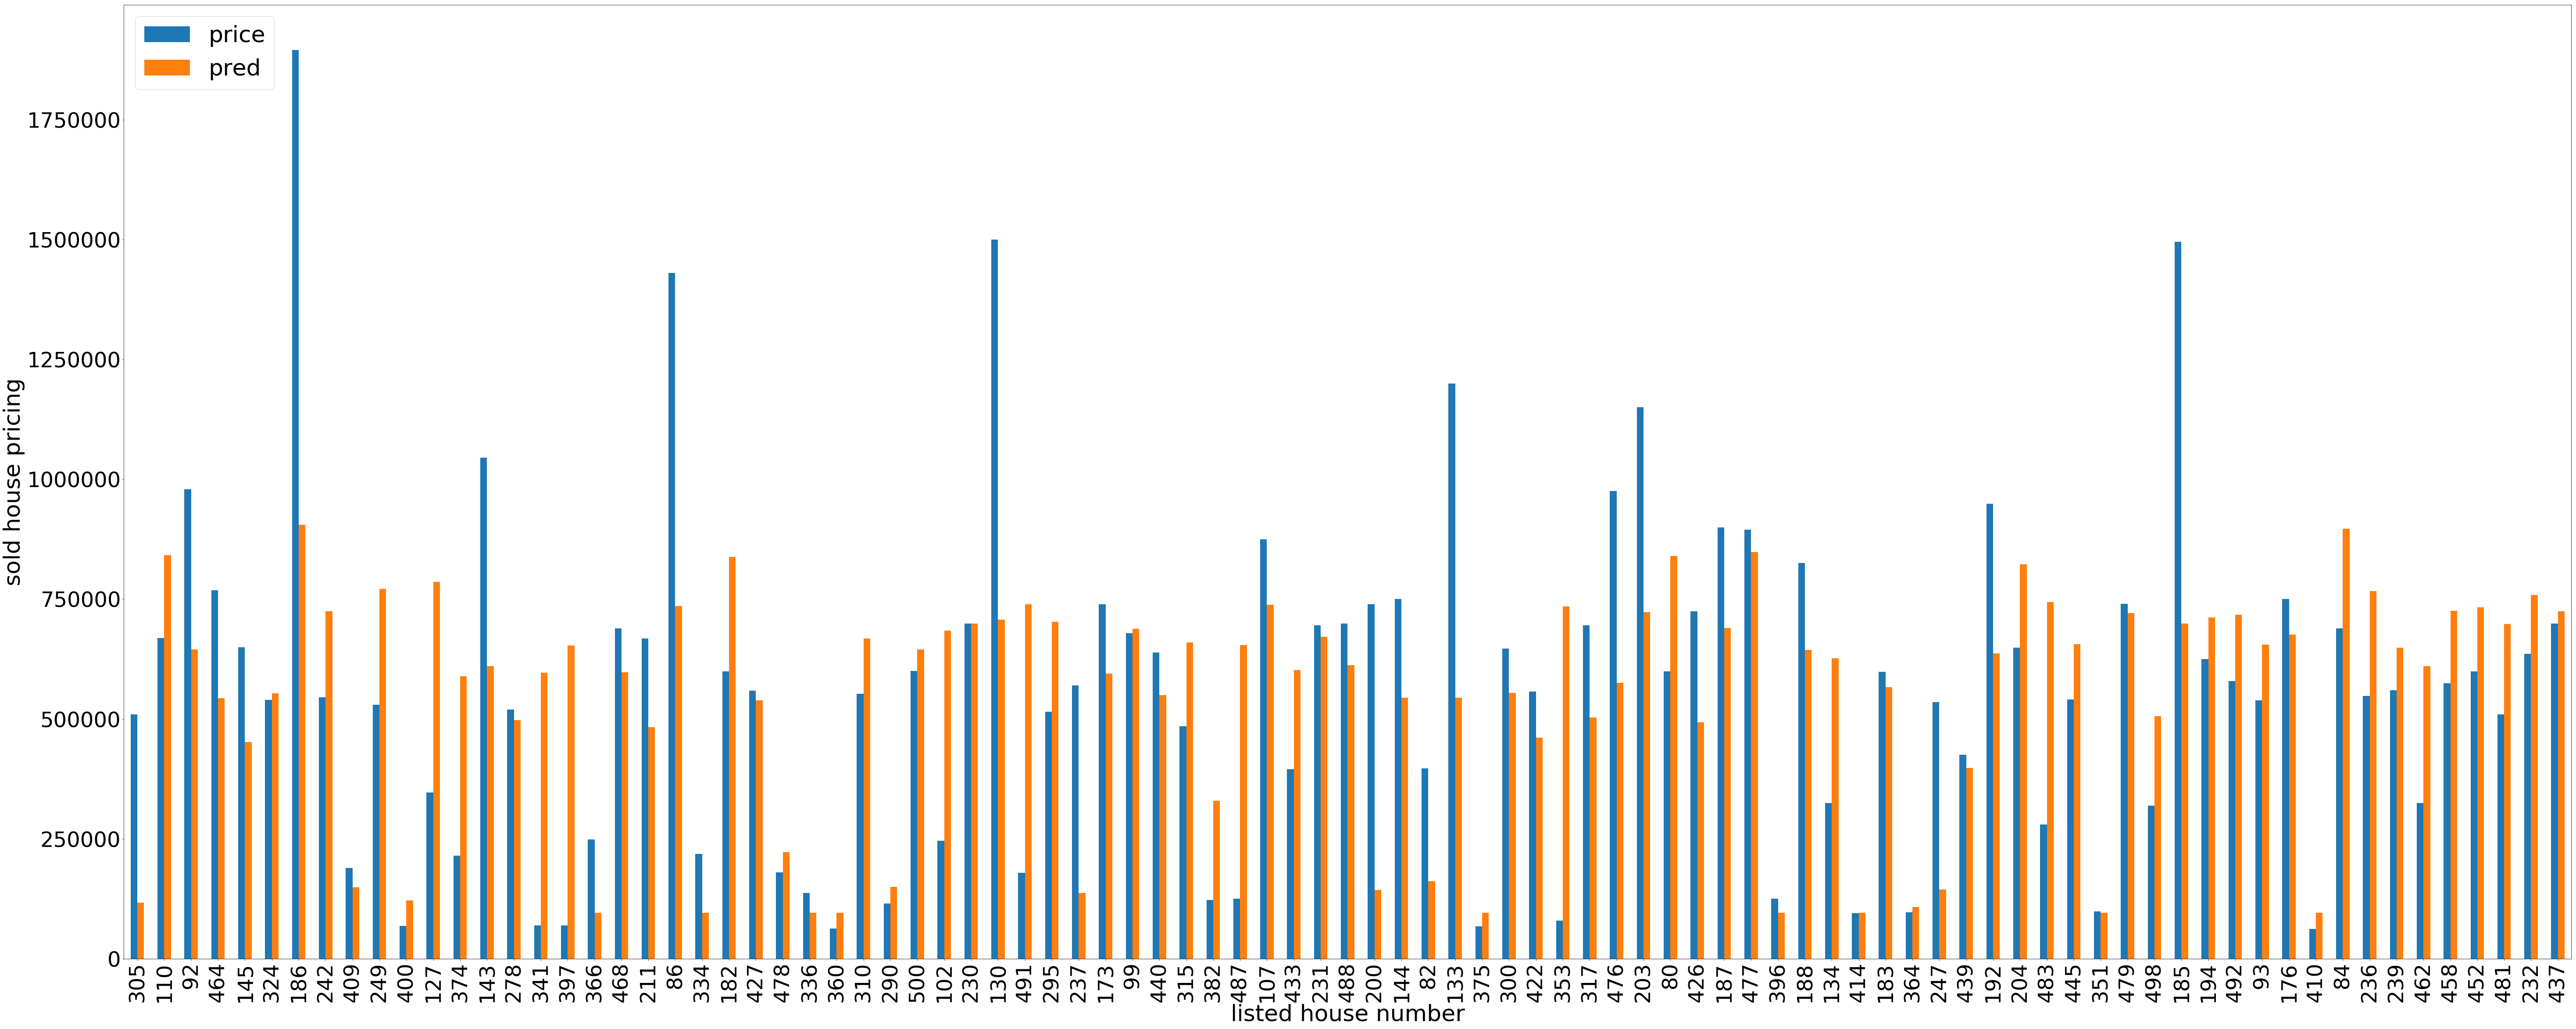

In [59]:
#visualize the difference in actual sold price and predicted price
subdf=testAttrX[['price','pred']]

ax = subdf.plot.bar(rot=90,figsize=(100,40),fontsize =48, legend=True)
ax.legend(loc=2, prop={'size': 52})
ax.set_xlabel("listed house number", fontsize=52)
ax.set_ylabel("sold house pricing", fontsize=52)

c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'percentage difference')

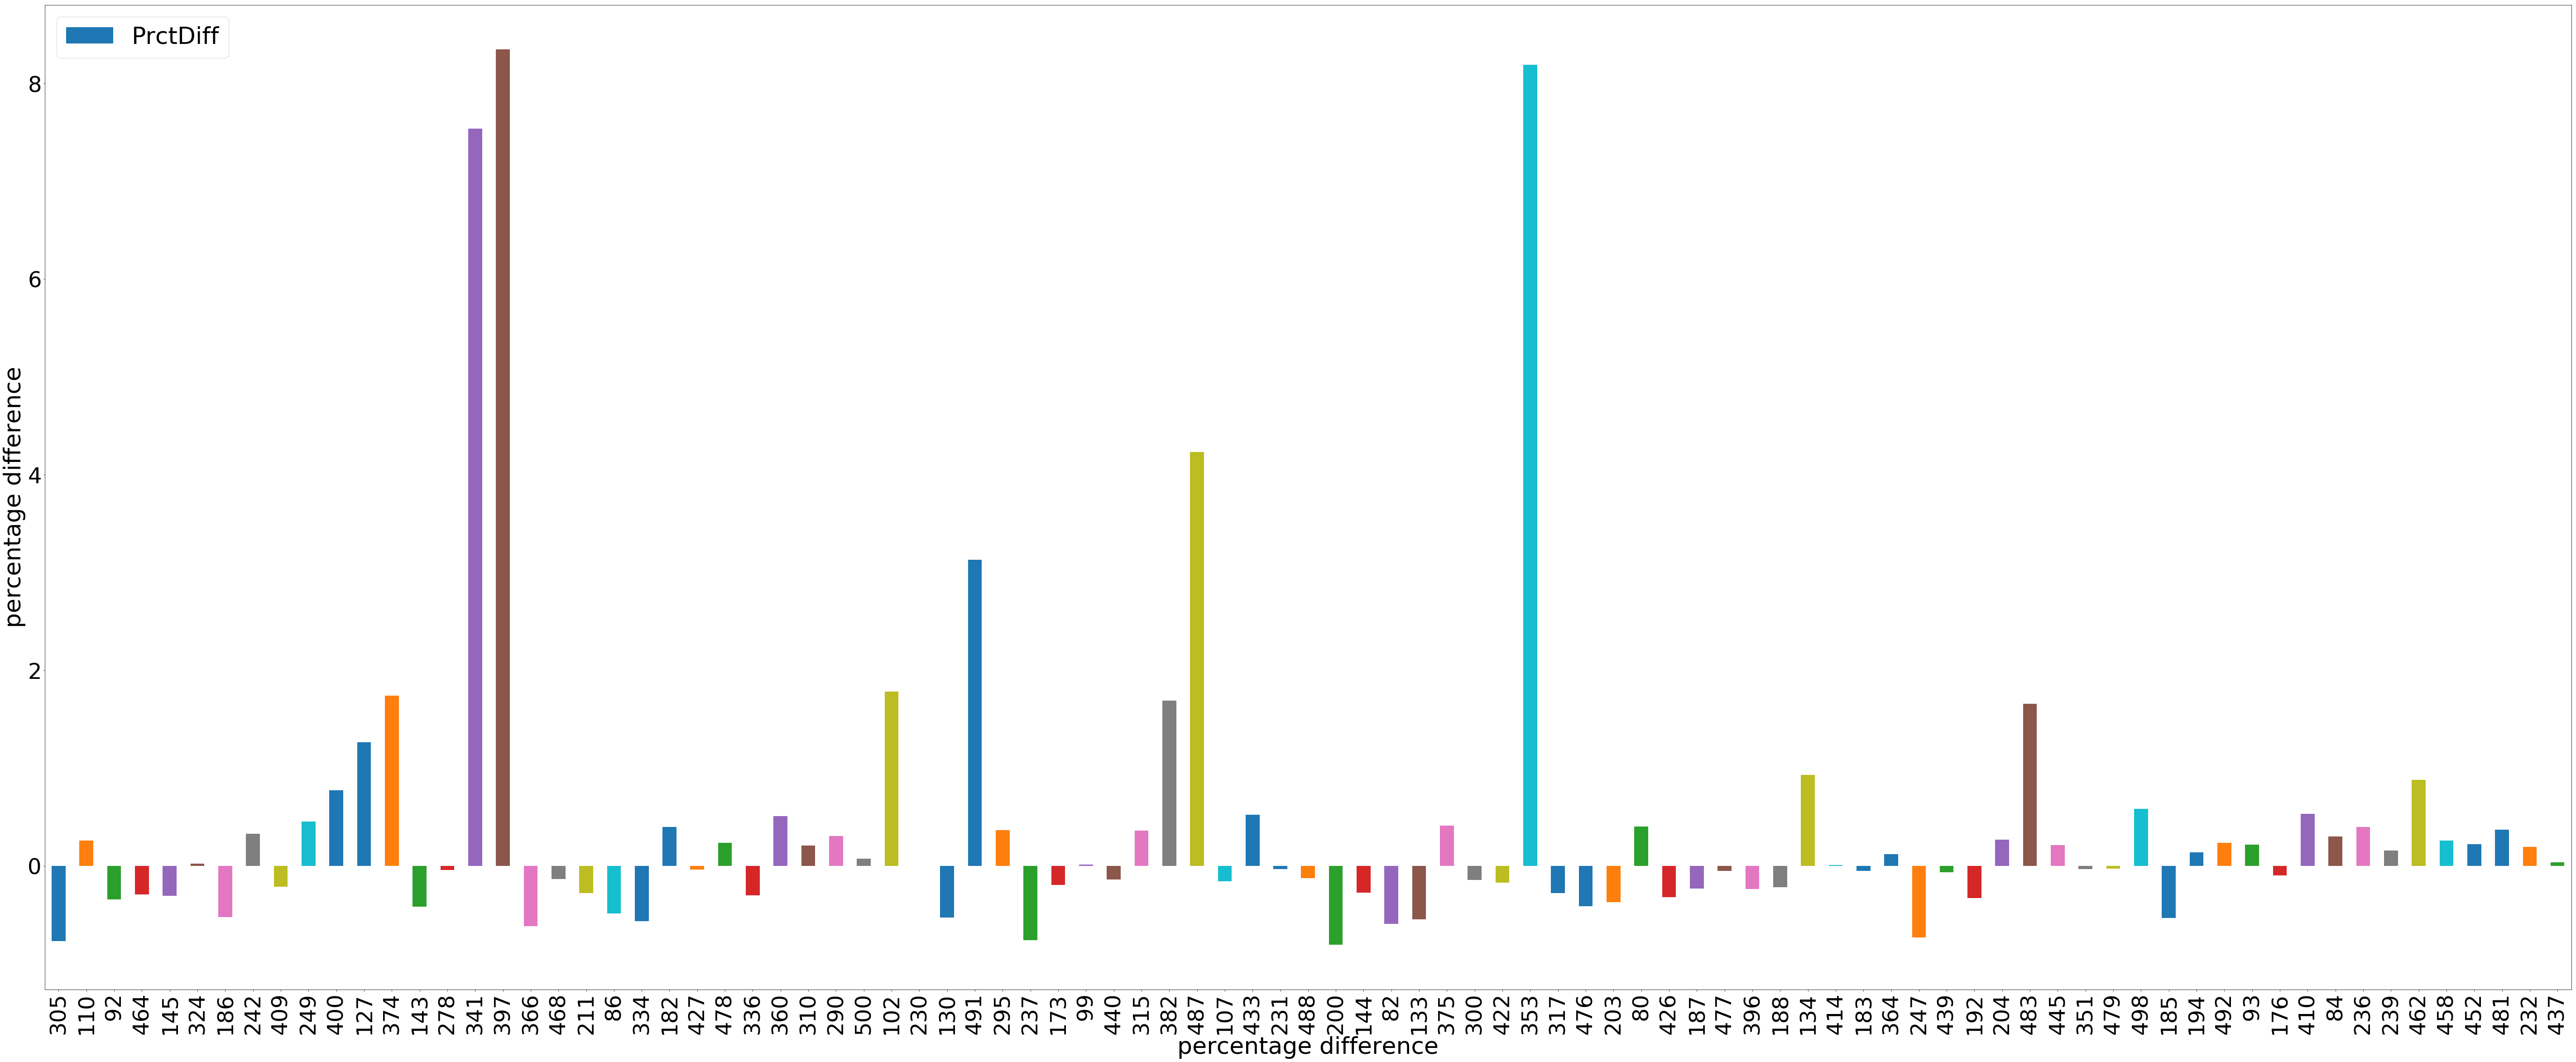

In [60]:
subdf['PrctDiff']=percentDiff/100
ax= subdf['PrctDiff'].plot.bar(rot=90,figsize=(100,40),fontsize =48, legend=True)
ax.legend(loc=2, prop={'size': 52})
ax.set_xlabel("percentage difference", fontsize=52)
ax.set_ylabel("percentage difference", fontsize=52)